## 9-1. 古典エラー
データ蓄積の方法は時間ともに初期化されてしまう揮発性のものと、原則としてほぼ劣化しない不揮発性のものに分類される。ここでは揮発性のメモリの一種であるDRAMのメモリセルを考える。
現代の計算機は0,1のバイナリ情報を、コンデンサに蓄えらえれた電子の量が多いか少ないかというアナログな連続量で表現する。（通信ならある周波数帯や時間区間に含まれる光子の数で表現する。）
ここではエネルギーが蓄えられた状態を1、エネルギーが完全に放出された状態を0とする。

こうしたアナログな量は、外部との相互作用により常に一定値にいることはない。電子は時間とともにトランジスタのリーク電流などによってあるレートで放出される。
従って、1の状態はしばらくたつと0の状態に変化してしまう。この変化は現代のデバイスではおよそ秒未満の無視できないスケールで起きる。
これは「操作の有無に寄らず時間の変化によって一定レートで起きるエラー」である。
こうしたエラーは古典デバイスでは「0,1が判定不能になるより十分前に、一定時間おきに残電子量を読み出し、その数に応じて充電しなおす」ことで訂正されている。
この操作はリフレッシュと呼ばれ、ユーザが意図せずとも定期的に行われる。当然、電源が落ちるとリフレッシュは行われなくなる。このことを指しDRAMを揮発メモリと呼ぶ。

リフレッシュが行われリークによる影響が無視できるとき、次に重要となるエラーの要因は中性子線によるトランジスタの誤動作である。
中性子線は宇宙線の一種であり、金属などを貫通するために防護が困難である。この中性子線がトランジスタを通過するとき、生じた電荷がトランジスタを誤動作させることがある。
従って、中性子線エラーは「何らかの操作がトリガーとなり、単発的に起きるエラー」である。
読み出しタイミングでないときトランジスタが動作しゲートが解放されると、コンデンサの状態はbit lineの状態に合わせて変化し意図しないものになってしまう。
このエラーによってビットが反転される確率は一般のユーザには無視できるほど小さいが、規模が非常に大きな計算では無視できなくなる。
仮に単位ビット当たりに単位時間で中性子線が衝突し誤動作する確率を$p$とすると、$n$ビットのメモリに$t$秒間の間１ビットも変化しない確率は
$q = (1-p)^{nt}$である。$n=10^{12}$で$t=10^{3}$とし、$q=0.99$を実現するためには、$p\sim 10^{-18}$でなければならない。

中性子線エラーのリークとの大きな違いは、リークはすぐさま確認すれば0,1の中間的な状態にあるため復帰が可能なものの、中性子線は生じた後にはもとはどの状態であったか知ることができない点にある。
このため、中性子線エラーが問題となる領域での応用では、誤り訂正機能の付いたECCメモリが利用される。ECCメモリでは後述の誤り訂正を行い、1bitまでのエラーを小さなオーバーヘッドで訂正する。



### 古典エラー訂正: 多数決
最も単純な符号は多数決である。多数決では個々のビットを$d$倍にコピーする。この時、$k$ビットの情報を$n:=dk$ビットで表現することになる。多数決の引き分けを防ぐため、$d$は奇数とする。
現実に存在する$n$ビットのことを物理ビット、実態として表現している$k$ビットのことを論理ビットと呼ぶ。

多数決では以下のように誤りの検知と訂正を行う。個々の論理ビットについて複製した$d$ビットの情報を読み出し、0,1のどちらが多いかを数える。そして、頻度が高かった値がその論理ビットの値であったと判定する。初期の値がどうあれ、符号化された状態は全ての値が同じであるから、$d$ビットの値が一つでも一致していない場合、何らかのエラーが生じていることが確信できる。従って$n$ビットが丸ごと反転しない限り必ず誤りを検知することができる。

誤りを訂正したい場合は半数以上のビットが正しい値を保持していれば正しい結果を得ることができる。それぞれのビットに1より十分小さい確率$p$でエラーが生じるとすると、半数以上のビットがエラーを起こす確率はおよそ$p^{\lfloor d/2 \rfloor+1}$である。
従って、$d$を2増やすごとに、多数決が失敗する確率はオーダーで$p$倍小さくなることがわかる。
最も単純な$k=1$の場合をシミュレートするコードを書くと以下のようになる。

In [1]:
import numpy as np

data = 1
d = 31
p = 0.01

print("original bit: {}".format(data))
state = np.repeat(data, d)
is_flipped = (np.random.rand(d)<p).astype(np.int)
state = (state + is_flipped)%2
if np.sum(state==0) < np.sum(state==1):
    majority = 1
else:
    majority = 0
        
print("decoded bit: {}".format(majority))

original bit: 1
decoded bit: 1


上記はランダムに成功不成功が変わるが、成功する確率は確率$p$に関する二項分布の累積として知ることができる。
横軸を各ビットのエラー確率、縦軸を復号の成功確率として、様々な奇数の$d$についてプロットすると以下のようになる。

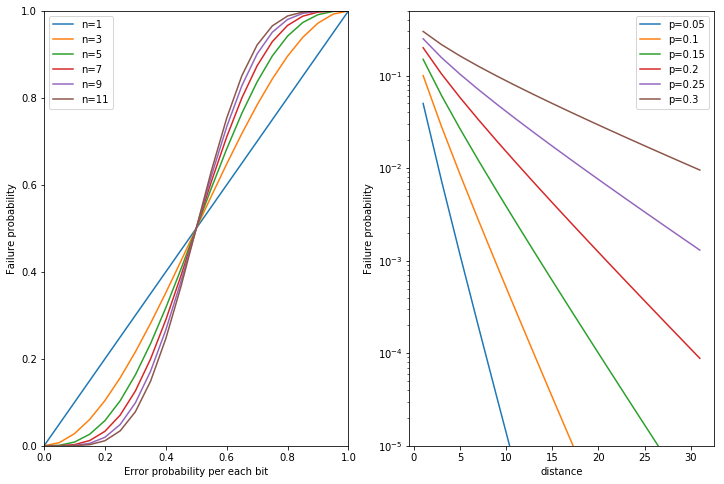

In [3]:
import numpy as np

d = 31
fail_prob_list = []
p_list = np.linspace(0,1,21)
for p in p_list:
    fail_prob = []
    binomial = [1]
    for m in np.arange(2,d+2):
        nbin = np.zeros(m)
        for i in range(m):
            if i!=0:
                nbin[i] += binomial[i-1]*p
            if i+1<m:
                nbin[i] += binomial[i]*(1-p)
        binomial = nbin
        if m%2==0:
            fail = np.sum(binomial[m//2:])
            fail_prob.append(fail)
    fail_prob_list.append(fail_prob)
fail_prob_list = np.array(fail_prob_list).T

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
for index,line in enumerate(fail_prob_list[:6]):
    plt.plot(p_list, line, label = "n={}".format(2*index+1))
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel("Error probability per each bit")
plt.ylabel("Failure probability")
plt.legend()

plt.subplot(1,2,2)
for index,line in enumerate(fail_prob_list.T[:7]):
    if index==0:
        continue
    distance_list = np.arange((d+1)//2)*2+1
    plt.plot(distance_list,line, label = "p={:.3}".format(p_list[index]))
plt.ylim(1e-5,0.5)
plt.yscale("log")
plt.xlabel("distance")
plt.ylabel("Failure probability")
plt.legend()
plt.show()

左のグラフから$p$がある一定値(今回は0.5)以下であれば、$d$を大きくすればするほど性能が良くなることがわかる。
一方、$p$がある値以上の場合、$d$を増やすとよくなるどころかむしろ性能が悪化してしまう。
このことから、多数決で誤り訂正を行うには、少なくとも各デバイスがある誤り率以下であることが必要条件となることがわかる。

このふるまいは量子符号を含むスケールする符号にたびたび見られる性質であり、このしきいとなるエラー確率のことをエラーしきい値(error threshold)と呼ぶ。一般の古典誤り訂正はエラーしきい値よりはるかに小さい値で行われるが、量子誤り訂正では現状のエラーがこのしきい値付近であるため、たびたび言及される。

右のグラフは$p$をしきい値以下の一定値に固定し、$d$を大きくしたときにどの程度復号の失敗確率が減少するかを指数プロットしたものである。$p$がしきい値より十分小さい場合、$d$を大きくすることで概ね指数的に復号の失敗確率が減少していくことがわかる。

### 線形符号
上記の多数決の枠組みは線形符号という符号の一種である。下記では線形符号の枠組みで多数決を解説する。
ある$k$ビットの情報$v$を$n=dk$ビットの情報$v'$に冗長化する操作は、$k \times n$の行列$G$を以下のように構成し、$v' = vG$という計算を行うと言い換えることができる。

In [5]:
import numpy as np
k = 4
m = 3
n = k*m
v = np.random.randint(2,size=k)
print("original vector: v\n{}".format(v))

G = np.zeros((k,n),dtype=np.int)
for y in range(k):
    G[y,y*m:(y+1)*m]=1
print("generator matrix: G\n{}".format(G))

vd = (v@G)%2
print("encoded vector: v' = vG\n{}".format(vd))

original vector: v
[0 1 0 1]
generator matrix: G
[[1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1]]
encoded vector: v' = vG
[0 0 0 1 1 1 0 0 0 1 1 1]


この行列$G$は生成行列という。

生成される$2^n$パターンの$n$ビット列のうち、$vG$の形で作られる高々$2^k$個の$n$ビット列を符号語と呼ぶ。符号語の集合を$W$としたとき、$w \neq w'$となる二つの符号語でハミング距離が短いもののハミング距離のことを符号の距離(distance)と呼ぶ。今の多数決の構成では、符号の距離は個々の論理ビットを複製する数$d$である。距離$d$以上の数のビットが一斉に反転してしまうとある符号語から別の符号語に変化してしまうため、現在の符号が正しく生成されたのか、他の符号にエラーが載ったものなのか区別がつかなくなる。このことから、エラーが生じるビット数が距離$d$未満であることがエラーが検知できる条件であることが分かる。

次に、mod 2のもとで$GH_c = 0$となり、かつ各行ベクトルが独立になるような$n \times (n-k)$行列$H_c$を考える。今回の場合、3ビットごとに二つの隣接したパリティを見る以下のような$H_c$が条件を満たす。

In [6]:
Hc = np.zeros((n,n-k),dtype=np.int)
for x in range(n-k):
    Hc[x//2*m+x%2:x//2*m+x%2+2,x]=1
print("check matrix: H\n{}".format(Hc))

print("G Hc = \n{}".format( (G@Hc)%2))

check matrix: H
[[1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]]
G Hc = 
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


$H_c$の列ベクトルは独立であるため、$2^n$パターンの$n$ビット列$w$のうち、$w H_c = 0$を満たすパターンは$2^n / 2^{n-k} = 2^k$個である。また、符号語の集合$W$に属する符号語$w$は、$w H_c = v G H_c = 0$である。したがって、符号語の集合$W$とは、$w H_c = 0$を満たすビット列の集合と言い換えることもできる。同時に$n$ビット列$w$が符号語ではない$(w \neq W)$ことは、$w H_c \neq 0$であることに等しい。この符号語に属している($w \in W$)ときかつその時に限り$0$になるベクトル$s = w H_c$のことを$w$のシンドロームと呼ぶ。

まとめると、符号語の集合$W$は二つの行列$G,H_c$のいずれでも特徴づけることができ、

$$
W = \{w \in \{0,1\}^n | \exists v \in \{0,1\}^k , w = vG \} \\
W = \{w \in \{0,1\}^n | w H_c = 0 \}
$$

である。

符号化した後にエラー$e$が生じた場合、エラーが起きた後の符号の状態は$v'+e$となった状態である。
この時、$v'+e$のシンドローム値$s = (v'+e)H_c$がすべて0であるかどうかを調べることで、エラーの検出を行える。
シンドローム値が一つでも0でない場合、何らかのエラーが生じている。シンドローム値がすべて0の場合、エラーは生じていないか、検知不可能な$d$ビット以上のエラーが生じていることがわかる。

In [7]:
p = 0.05
print("encoded vector: v'\n{}".format(vd))
e = np.random.choice([0,1],size=len(vd),p = [1-p,p])
print("error vector: e\n{}".format(e))
vde = (vd+e)%2
print("encoded vector with noise: v'+e\n{}".format(vde))
s = (vde@Hc)%2
print("syndrome values: s = (v'+e)Hc\n{}".format(s))

encoded vector: v'
[0 0 0 1 1 1 0 0 0 1 1 1]
error vector: e
[0 0 0 0 0 0 0 0 0 0 0 0]
encoded vector with noise: v'+e
[0 0 0 1 1 1 0 0 0 1 1 1]
syndrome values: s = (v'+e)Hc
[0 0 0 0 0 0 0 0]


$GH_c=0$という性質から、$s =(v'+e)H_c = vGH_c + eH_c = eH_c$となる。つまり、シンドローム値は初期状態のベクトル$v$と独立であることが分かる。

$n$ビットの多数決は$v'+e$を左から$m$個ずつ見て多数決を行えばよい。

In [8]:
p = 0.1
print("encoded vector: v'\n{}".format(vd))
e = np.random.choice([0,1],size=len(vd),p = [1-p,p])
print("error vector: e\n{}".format(e))
vde = (vd+e)%2
print("encoded vector with noise: v'+e\n{}".format(vde))
s = (vde@Hc)%2
print("syndrome values: s = (v'+e)Hc\n{}".format(s))
def decode(vde,k,m):
    for x in range(k):
        subset = vde[x*m:(x+1)*m]
        val = np.argmax(np.bincount(subset))
        vde[x*m:(x+1)*m] = val
    return vde
vde_recovery = decode(vde,k,m)
print("recovered vector: \n{}".format(vde_recovery))

encoded vector: v'
[0 0 0 1 1 1 0 0 0 1 1 1]
error vector: e
[0 0 0 0 0 0 0 0 0 0 0 1]
encoded vector with noise: v'+e
[0 0 0 1 1 1 0 0 0 1 1 0]
syndrome values: s = (v'+e)Hc
[0 0 0 0 0 0 0 1]
recovered vector: 
[0 0 0 1 1 1 0 0 0 1 1 1]


上記の復号はエラーを大きくしていくと、$m$の半数以上が間違えて訂正に失敗することがあることが分かる。

$e H_c=0$となる$0$でないベクトル$e$が生じた場合、そのようなエラーは訂正することができない。すなわち、符号の距離$d$は検査行列$H_c$にに対して

$$
d := \min w(e) \, \text{s.t.} \, H_e e = 0
$$

という値だと考えることもできる。

### 水平垂直パリティ検査符号
現実の誤り訂正では多数決の手法はあまり性能が良くないためそれほど使われない。ここでは現実の誤り訂正でよく使われるパリティ検査符号の一例として、水平垂直パリティ検査符号の枠組みを学ぶ。

パリティとは、与えられた複数のビットの和を2で割った余り、すなわち1の数の偶奇を意味する。(1,1,1)のパリティは1、(0,1,1)のパリティは0である。
パリティ検査符号は、元の情報のデータについてのいくつかのパリティを保持することで誤りの検知や訂正を可能にする。
元の情報やパリティにエラーが生じた場合、パリティの値と元の情報に整合性が保たれなくなるためエラーを検出することができる。

最もシンプルなパリティ検査符号はチェックサムである。チェックサムは小さなブロック$(x_1,\ldots, x_b)$ごとに、ブロックに含まれるビット列のパリティ$p= \sum_i x_i \mod 2$をチェックサムとして記入しておく。
もし、伝送の途中でブロック中のビットやチェックサムのビットの記入を高々1bit誤った場合、ブロックに含まれるビット列のパリティを再計算すると保持するパリティ$p$と整合性が取れなくなる。
従って、ブロックかパリティのどこかにビットエラーが生じたことがわかる。ただし、この方法はどこでエラーが生じたかを知ることはできないし、2ビットエラーが生じた場合はエラーを検知することもできない。

In [9]:
import numpy as np
length = 16
p = 0.05

# set random bitarray
bitstring = np.random.randint(2,size = length)
checksum = np.sum(bitstring)%2
print("original bitarray: {}". format(bitstring))
print("checksum: {}".format(checksum))

# error occurs
error = np.random.choice([0,1], size = length, p = [1-p, p])
print("error:             {}". format(error))

bitstring = (bitstring + error)%2
print("noisy bitarray:    {}". format(bitstring))
new_checksum = np.sum(bitstring)%2
print("checksum: {}".format(new_checksum))

# verify checksum
if checksum == new_checksum:
    print("No error detected")
else:
    print("Error detected!")

original bitarray: [0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0]
checksum: 1
error:             [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
noisy bitarray:    [0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1]
checksum: 0
Error detected!


1ビットのビットエラーの検知だけでなく訂正を行うには、どこでエラーが生じたかを分かるようにしなければいけない。
これを実現するナイーブな手法は、水平垂直パリティ検査という手法である。
保護する対象を$k=16$ビットをベクトルとし、これを$4*4$の行列に配置する。
ここで、各行のベクトルのパリティと各列のベクトルのパリティを$8$ビット保存しておく。
この場合、もし$k$ビットの中でエラーが生じると、一つの列と行のパリティと整合が取れなくなる。この場合、整合が取れない列と行に一致するデータビットが反転したと判定する。
もし、行のパリティビットにエラーが生じた場合、列のパリティは全て整合が取れているはずである。このように一方のパリティだけにエラーがある場合、パリティが反転したと結論付ける。列のエラーも同様である。
こうすることで、どの場所でビットエラーが生じてもそれが1ビットであれば原因を特定できる。このコードの距離は3ビットであり$[24,16,3]$である。一般には$[w^2+2w,w^2,3]$である。


In [10]:
import numpy as np
width = 4
height = 4
size = width*height
p = 0.03

def show(bitmatrix, vertical_parity, horizontal_parity):
    for y in range(height):
        print("{} | {}".format(bitmatrix[y,:], horizontal_parity[y] ))
    print("-"*width*2)
    print("{}".format(vertical_parity ))
    print()

# set random bitarray
bitstring = np.random.randint(2,size=size)
print("original bitarray: {}". format(bitstring))

# check horizontal and vertical parity
bitmatrix = bitstring.reshape( (height,width) )
vertical_parity = np.sum(bitmatrix, axis = 0)%2
horizontal_parity = np.sum(bitmatrix, axis = 1)%2
print("stored as : ")
show(bitmatrix,vertical_parity, horizontal_parity)

# error occurs
encoded_size = size + width + height
error = np.random.choice([0,1], size = encoded_size, p = [1-p, p])
bitmatrix = (bitmatrix + error[:size].reshape((height,width)))%2
vertical_parity = (vertical_parity + error[size:size+width])%2
horziontal_parity = (vertical_parity + error[size+width:])%2

# result
print("result is : ")
show(bitmatrix,vertical_parity, horizontal_parity)

# verify checksum
result_vertical_parity = np.sum(bitmatrix, axis = 0)%2
result_horizontal_parity = np.sum(bitmatrix, axis = 1)%2
vertical_flip_count = np.sum((result_vertical_parity + vertical_parity)%2)
horizontal_flip_count = np.sum((result_horizontal_parity + horizontal_parity)%2)

if vertical_flip_count == 0 and horizontal_flip_count == 0:
    print("No error detected")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 1 and horizontal_flip_count == 0:
    print("Error occurs on vertical parity")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 0 and horizontal_flip_count == 1:
    print("Error occurs on horizontal parity")
    print("decoded bitarray: ")
    show(bitmatrix, result_vertical_parity, result_horizontal_parity)
elif vertical_flip_count == 1 and horizontal_flip_count == 1:
    print("Error occurs on data bit")
    print("decoded bitarray: ")
    x = np.argmax((result_vertical_parity + vertical_parity)%2)
    y = np.argmax((result_horizontal_parity + horizontal_parity)%2)
    bitmatrix[y,x] = (bitmatrix[y,x]+1)%2
    show(bitmatrix, vertical_parity, horizontal_parity)
else:
    print("Too many error occurs")

original bitarray: [1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0]
stored as : 
[1 0 0 1] | 0
[0 0 0 1] | 1
[0 0 1 1] | 0
[1 0 0 0] | 1
--------
[0 0 1 1]

result is : 
[1 1 0 1] | 0
[0 0 0 1] | 1
[0 1 1 1] | 0
[1 0 0 0] | 1
--------
[0 0 1 1]

Too many error occurs


水平垂直パリティ検査符号も多数決と同様に生成行列と検査行列を考えることができる。
簡単のために、$2 \times 3$の6ビットに対する水平垂直パリティ検査の場合を例に考える。
水平垂直パリティ検査で符号化するビットの横ベクトルを$v$とする。この時、$(1,2,3)$番目のパリティを観測する計算は、$1,2,3$番目のみが1で他が0となっているベクトル$w = (1,1,1,0,0,0)$を用意し、ベクトル間の内積$v w^{\rm T} \mod 2$を計算することに等しい。従って、元のデータに追加されるパリティビットは以下のような行列$A$をmod 2のもとで作用することで生成できる。なお、以降のバイナリビット間の演算では特に断りが無い限りはmod 2を省略する。

In [11]:
A = np.array([
    [1 , 0 , 1 , 0 , 0],
    [1 , 0 , 0 , 1 , 0],
    [1 , 0 , 0 , 0 , 1],
    [0 , 1 , 1 , 0 , 0],
    [0 , 1 , 0 , 1 , 0],
    [0 , 1 , 0 , 0 , 1]
])
print(A)

[[1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]
 [0 1 1 0 0]
 [0 1 0 1 0]
 [0 1 0 0 1]]


この時、パリティの値を並べたベクトル$p$は$p = vA$であり、符号化後のバイナリベクトルは$v' = (v,p)$である。従って生成行列として$k \times n$行列$G$を$G = (I, A)$と置けば、$v' = v G$という形にできる。

符号化したバイナリベクトルにはエラー$e$が生じる。この時、$e$のうちデータ部に生じたエラーを$e_v$、パリティ部に生じたエラーを$e_p$とする。エラーが生じた後のバイナリベクトルは$v'+e = (v+e_v, p+e_p)$となる。水平垂直パリティ検査では、エラーが生じた後にパリティ値が一致しているかどうかをもとにエラーが生じたかを判断する。このことを式で書くと、

$$
(v + e_v)A = p + e_p
$$

が成り立つか否かが、エラーを検知するかどうかの判定に等しい。$p=vA$を用いて上記の等式を整理すると、エラーが検知されない条件は

$$
e_v A + e_p = (e_v, e_p) \left(\begin{matrix} A \\ I \end{matrix}\right) = 0
$$

である。行列$H_c$を$H_c = \left( \begin{matrix} A \\ I \end{matrix} \right)$と置くと、

$$
G H_c = (I, A) \left(\begin{matrix} A \\ I \end{matrix}\right) = A + A = 0
$$

である。

In [12]:
G = np.hstack( (np.eye(A.shape[0]), A) )
Hc = np.vstack( (A, np.eye(A.shape[1])) )
print("generator matrix: G\n{}\n".format(G))
print("check matrix: Hc \n{}\n".format(Hc))
print("GHc = \n{}\n".format( (G@Hc)%2 ))

generator matrix: G
[[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]]

check matrix: Hc 
[[1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

GHc = 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



数値的にも確かに$GH_c = 0$となることが分かる。$H_c$は$n \times (n-k)$行列で、かつ列ベクトルは単位行列の部分行列を持つことから明らかに列ごとに独立であり、確かに検査行列の性質を満たしている。

このとき、シンドローム値$s$は$s = e H_c$となる。シンドローム値が全て0の時、符号はエラーが生じていないと判定する。もちろん、大きなエラーが生じている場合、エラーが生じているにもかかわらず$s=0$となりエラーが無いと判定されることもある。

$s \neq 0$である場合、何らかのエラーが起きていることはわかる。この状態でエラーを訂正するには、$(v'+e)$の値から符号化前の$v$を推測しなければならない。今回の場合、冒頭のコードで示したような方法でエラーが一つまでならデータビットとパリティビットのどこにエラーがあるのかを$O(1)$で特定することができる。

パリティ検査符号の枠組みをまとめると以下のようになる。

- 符号：生成行列$G$と検査行列$H_c$で特徴づけられる。これらは$GH_c = 0$を満たす。
- 符号化前：$k$-bitの横ベクトルデータ $v$ がある。
- 符号化: $k \times n$の生成行列$G$を用いて、符号化した状態$v'$は$v'=vG$となる。
- エラー: 符号化後の$v'$にランダムに$n$-bit列 $e$ が足される。
- エラー検査: $n \times (n-k)$の検査行列$H_c$を用いてシンドローム$s = e H_c$が得られる。$s \neq 0$ならばエラーがあると検知できる。$s=0$ならば、エラーが生じていないか、検査できる限界以上のエラーが生じている。
- エラー訂正: $(v'+e)$の値に従って、$k$-bitの横ベクトルデータ $v$ を推測する。$v'+e$から$v$を求めるアルゴリズムを復号アルゴリズムと呼ぶ。
- 距離: $e H_c = 0$となる$e$の最小weightが符号の距離$d$である。

パリティ検査符号は非常に広い枠組みであり、例えばECCメモリではハミング符号と呼ばれるパリティ検査行列の一種が用いられている。




### 一般の線形符号のケース

上記では多数決、チェックサム、水平垂直検査という特定の例を挙げたが、実際に使用する際には目的に対し最も性能の良い符号がほしい。しかし、一般に与えられた$(n,k,d)$に対して最適な線形符号$G,H_c$を求めることは組み合わせ論の問題となり、一般に困難である。

また、仮に最適な$(G,H_c)$という符号を与えられても復号に関して問題がある。ナイーブな復号アルゴリズムの例は、シンドローム$s$を観測した時、$s = e'H_c$を満たすような$e'$のうち、最も少ないビットにエラーを起こすものを起きたエラーとみなし、$(v' + e + e')$が正しい符号語になると期待して復元を試みる最小距離複合である。上記の最適化は

$$
\min_{e \in \{0,1\}^n} w(e') \, \text{s.t.} \, s = e' H_c 
$$

という$n$-bitの0,1計画問題となるため、最小距離複合は一般には符号のサイズに対してNP困難である。しかも、この復号は実際には最適な復号とと一致するとは限らない。一方、符号や起きるエラーの種類を限定すると効率的に最小距離複合が実施でき、かつ多くの場合この復号方法は最適に近い複合である。例えば多数決は常に最小距離複合が可能であり、水平垂直パリティ検査符号では生じるエラーを $w(e)=1$ に限定すれば$O(1)$で最小距離複合が可能である。

### 線形符号上での演算
ノイジーな通信路に情報を通す場合はパリティ検査符号で符号化された情報を転送するだけである場合でよい。しかし、計算機自体がノイジーな場合、パリティ検査符号で符号化した状態で計算を行わなければならない。例えば、CPU自体がノイジーであり、符号化した状態のままで計算を行いたい場合は、計算のたびに復号してしまっては符号化の意味がない。

上記の水平垂直パリティ検査を用いる場合、行列の$(i,j)$要素に対するビット反転操作を行う場合、この操作がエラーとして検知されないようにするには関連するパリティの値も更新しなくてはいけない。つまり、$1$ビットを更新する目には、符号化されたビット列に対して$3$ビットの操作が必要となる。

より一般的には、$v$に対するビット反転操作$o$を考えると、$v \rightarrow v+o$とするには、符号化された空間で$oB$のビット反転が必要になる。操作のコストを考えると、ある論理ビットを操作するときに実際に操作せねばならないビットの数は少なければ少ないほど良い。
この時、論理ビットの反転のために実際に反転しなければいけないビットの数は高々$\max_i w(G_i)$である。ただし、$G_i$は$G$の$i$行ベクトルである。水平垂直パリティ検査では$G$の行のweightはすべて3である。

### 低密度パリティ検査符号
宇宙との通信など通信できる時間が限られていたり通信路が劣悪にならざるを得ない場合、できるだけ限界に近いレートで大量のデータを送りたい。このことが、符号化や復号にかかる計算コストは大きくとも良いので、符号化するビット数あたりの論理誤り率が最も小さくなる符号を作るモチベーションとなる。

通信路のノイズが既知である場合、ノイズのある通信路で送信可能な情報量のレートの限界はシャノン限界として計算できる。このレートはこれは構成することができる符号の性能の限界を意味する。低密度パリティ検査符号はこのシャノン限界に近い性能を実現する符号である。

低密度パリティ検査符号では、検査行列$H_c$が疎行列となるパリティ検査符号の総称である。ここでいう疎行列とは、各列に含まれる$1$の数が高々$O(k)$程度であることを意味する。すなわち、個々のシンドローム値は$O(k)$個のビットのエラーのパリティで表現できるということである。

低密度パリティ検査符号の利点はその性能がシャノン限界に近い点である。一方、低密度パリティ検査符号の欠点は、復号の計算量的な困難さである。この困難を回避するため、信頼伝播法といった近似アルゴリズムが復号のためにしばしば用いられる。

信頼伝播法では、次のようなグラフを考える。符号化後のビットをノードとみなす。あるパリティ値があるデータビットのエラーをパリティの一部に含むとき、対応するパリティビットのノードからデータビットのノードへ無向エッジを張る。こうして、$n$頂点が$nO(k)$個の辺で繋がれたの無向グラフ$G(V,E)$が完成する。信頼伝播法はこのグラフ上での逐次的な最適化を状態が符号後となるまで繰り返す。
信頼伝播法の性能はグラフ$G$における最小のループが大きければ大きいほど良いことが知られている。したがって、そのようなグラフを構築するべく、様々な低密度パリティ検査符号の構築方法が提案されている。

